# Homework 1: Score Matching and Langevin Dynamics

In this section, we will implement Langevin Dynamics on a simple 2D Mixture of Gaussians Model.

It is prohibited to use the library ```torch.distributions``` throughout this homework, as well as any other libraries that do similar calculations such as ```scipy.stats```.

Note that GPUs will not help in any part except the final section with the generation of images (everything else runs in less than a second), so it is recommended to run this part of the homework on a local CPU.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import random
import matplotlib.pyplot as plt

## Part 1: Computing the density and score of a Gaussian Mixture Model

A Gaussian Mixture Model is a distribution that is the combination of several Gaussian distributions, such as the following:

$$
X | Y \sim \mathcal{N}(\mu_1, \sigma_1 I)Y + \mathcal{N}(\mu_2, \sigma_2 I)(1 - Y)
$$

where $Y \sim \text{Ber}(p)$. In our case, $X \in \mathbb{R}^2$.

Implement the following functions to compute the density and score of a GMM. You can add any other functions required. For score computation, do not use torch's autograd (it will greatly hinder the performance).

In [2]:
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])

sigma_1 = torch.sqrt(torch.tensor(0.1))
sigma_2 = torch.sqrt(torch.tensor(0.1))

p_first = torch.tensor(0.15)  # The probability that I will sample from the first distribution.

In [5]:
def density_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p):
    """
    :param X: input data: tensor of shape (N, 2)
    :param mu_1: mean of the first Gaussian
    :param mu_2: mean of the second Gaussian
    :param sigma_1: standard deviation of the first Gaussian
    :param sigma_2: standard deviation of the second Gaussian
    :param p: probability of the first Gaussian
    :return: density of the Gaussian Mixture Model at point X: tensor of shape (N,)
    """
    d = X.shape[-1]  # dimensionality

    def gaussian_density(x, mu, sigma):
        diff = x - mu
        exponent = -0.5 * torch.sum(diff ** 2, dim=-1) / (sigma ** 2)
        coef = 1.0 / ((2 * torch.pi) ** (d / 2) * (sigma ** d))
        return coef * torch.exp(exponent)

    density_1 = p * gaussian_density(X, mu_1, sigma_1)
    density_2 = (1 - p) * gaussian_density(X, mu_2, sigma_2)
    return density_1 + density_2

In [6]:
def score_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p):
    """
    :param X: input data: tensor of shape (N, 2)
    :param mu_1: mean of the first Gaussian: tensor of shape (2,)
    :param mu_2: mean of the second Gaussian: tensor of shape (2,)
    :param sigma_1: standard deviation of the first Gaussian: tensor of shape (1,)
    :param sigma_2: standard deviation of the second Gaussian: tensor of shape (1,)
    :return: score of the Gaussian Mixture Model at point X: tensor of shape (N, 2, 2)
    """
    X = X.clone().detach().requires_grad_(True)

    gmm_log = torch.log(density_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p))

    score = torch.autograd.grad(
        outputs=gmm_log,
        inputs=X,
        grad_outputs=torch.ones_like(gmm_log),
        create_graph=False
    )[0]

    return score

### Visualization

Using a heatmap (with plt.imshow) and an arrow plot (plt.quiver), generate a plot of the density function and score.

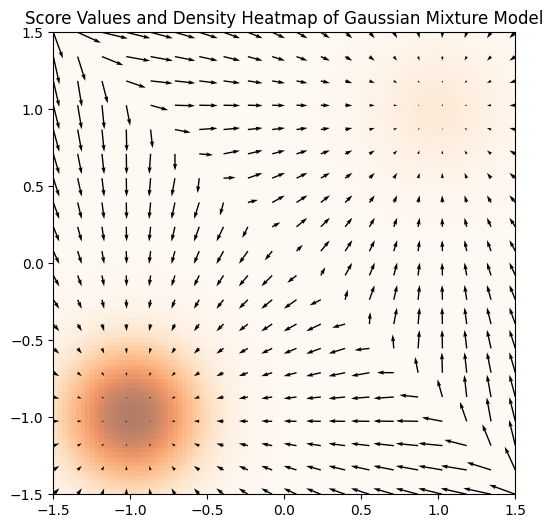

In [7]:
# Steps:
# 1. Create a grid from -1.5 to 1.5 in both dimensions, with 100 points in each dimension (using torch.linspace and torch.meshgrid)
# 2. Compute the density of the Gaussian Mixture Model at each point on the grid and store it in a tensor of shape (100, 100)
# 3. For the quiver plot, create a grid from -1.5 to 1.5 in both dimensions, with 20 points in each dimension
# 4. Compute the score of the Gaussian Mixture Model at each point on the grid and store it in a tensor of shape (20, 20, 2)
# 5. Create a quiver plot with the grid points as the X and Y coordinates and the score as the U and V components
# 6. Create a heatmap of the density, with the grid points as the X and Y coordinates and the density as the color, becoming darker as the density is larger

DENSITY_GRID_SIZE = 100
SCORE_GRID_SIZE = 20

x = torch.linspace(-1.5, 1.5, DENSITY_GRID_SIZE)
y = torch.linspace(-1.5, 1.5, DENSITY_GRID_SIZE)
xx, yy = torch.meshgrid(x, y, indexing='ij')
density_grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

density_values_flat = density_gmm(density_grid, mu_1, mu_2, sigma_1, sigma_2, p_first)
density_values = density_values_flat.reshape(DENSITY_GRID_SIZE, DENSITY_GRID_SIZE)

x_s = torch.linspace(-1.5, 1.5, SCORE_GRID_SIZE)
y_s = torch.linspace(-1.5, 1.5, SCORE_GRID_SIZE)
xx_s, yy_s = torch.meshgrid(x_s, y_s, indexing='ij')
score_grid_points = torch.stack([xx_s, yy_s], dim=-1).reshape(-1, 2)

score_values_flat = score_gmm(score_grid_points, mu_1, mu_2, sigma_1, sigma_2, p_first)
score_values = score_values_flat.reshape(SCORE_GRID_SIZE, SCORE_GRID_SIZE, 2)

score_grid = torch.stack([xx_s, yy_s], dim=-1)

plt.figure(figsize=(8, 6))

plt.imshow(density_values, extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='Oranges', alpha=0.6)
plt.quiver(score_grid[:, :, 0], score_grid[:, :, 1], score_values[:, :, 0], score_values[:, :, 1], color='black')
plt.title('Score Values and Density Heatmap of Gaussian Mixture Model')
plt.show()

Example output on standard Gaussian:

![image.png](attachment:image.png)

## Part 2: Training a score network

Implement a model that is able to compute the score of a given point sampled from the GMM.

In [8]:
class ScoreMatcher(nn.Module):
    def __init__(self, input_dim):
        super(ScoreMatcher, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.fc4(x)

In [9]:
def generate_gmm_data(mu_1, mu_2, sigma_1, sigma_2, p, size):
    """ Generate synthetic data by sampling from the GMM density """
    # Create a grid of random points (uniformly distributed) to sample from the GMM density
    X = torch.rand(size, 2) * 3 - 1.5  # Uniform distribution from -1.5 to 1.5 in both dimensions

    densities = density_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p)
    densities = densities / densities.sum()
    idxs = torch.multinomial(densities, size, replacement=True)  # Sample indices based on density probabilities
    sampled_X = X[idxs]

    return sampled_X  # Only return the sampled data
def train(mu_1, mu_2, sigma_1, sigma_2, p, train_size, num_epochs, lr):
    """ Return a trained ScoreMatcher model """
    model = ScoreMatcher(input_dim=mu_1.shape[0])  # Assuming the input dimension matches the length of mu_1
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train = generate_gmm_data(mu_1, mu_2, sigma_1, sigma_2, p, train_size)  # Only get X_train

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        score = model(X_train)
        true_score = score_gmm(X_train, mu_1, mu_2, sigma_1, sigma_2, p)
        loss = F.mse_loss(score, true_score)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


Print the loss value at each epoch. Make sure the loss is lower than 0.01

In [10]:
gmm_score_model = train(mu_1, mu_2, sigma_1, sigma_2, p_first, 1000, 1000, 0.01)

Epoch [100/1000], Loss: 0.0173
Epoch [200/1000], Loss: 0.0947
Epoch [300/1000], Loss: 0.0005
Epoch [400/1000], Loss: 0.0009
Epoch [500/1000], Loss: 0.0002
Epoch [600/1000], Loss: 0.0027
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0005
Epoch [1000/1000], Loss: 0.0001


Create a similar visualization to the visualization you created with the true score, replacing the true score with the model.

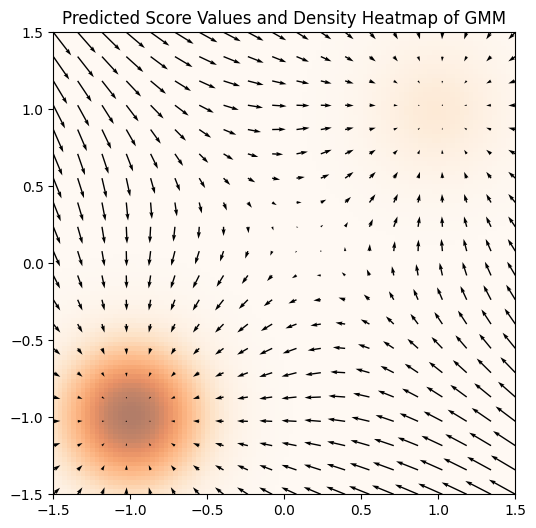

In [11]:
DENSITY_GRID_SIZE = 100
SCORE_GRID_SIZE = 20

x = torch.linspace(-1.5, 1.5, DENSITY_GRID_SIZE)
y = torch.linspace(-1.5, 1.5, DENSITY_GRID_SIZE)
xx, yy = torch.meshgrid(x, y, indexing='ij')
density_grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

density_values_flat = density_gmm(density_grid, mu_1, mu_2, sigma_1, sigma_2, p_first)
density_values = density_values_flat.detach().numpy().reshape(DENSITY_GRID_SIZE, DENSITY_GRID_SIZE)

x_s = torch.linspace(-1.5, 1.5, SCORE_GRID_SIZE)
y_s = torch.linspace(-1.5, 1.5, SCORE_GRID_SIZE)
xx_s, yy_s = torch.meshgrid(x_s, y_s, indexing='ij')
score_grid_points = torch.stack([xx_s, yy_s], dim=-1).reshape(-1, 2)

score_values_flat = gmm_score_model(score_grid_points)
score_values = score_values_flat.detach().numpy().reshape(SCORE_GRID_SIZE, SCORE_GRID_SIZE, 2)

score_grid = torch.stack([xx_s, yy_s], dim=-1)

plt.figure(figsize=(8, 6))

plt.imshow(density_values, extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='Oranges', alpha=0.6)
plt.quiver(score_grid[:, :, 0], score_grid[:, :, 1], score_values[:, :, 0], score_values[:, :, 1], color='black')
plt.title('Predicted Score Values and Density Heatmap of GMM')
plt.show()


Compare the visualizations and explain what could be causing the differences.

Overall both of the visualizations are quite similar. We can notice that in areas where the density is low then the visualizations appear quite differently. The model will overfit on it's given training set and thus will contribute to the differences with the actual density from the first visualization.

## Part 3: Sampling

In this section we will sample from our distribution using several methods:
1. Directly sampling using torch functions
2. Using Langevin Dynamics using the model that we trained.
3. Using Annealed Langevin Dynamics using the true score function.

Sample 1000 points from the GMM and display them using a scatterplot.

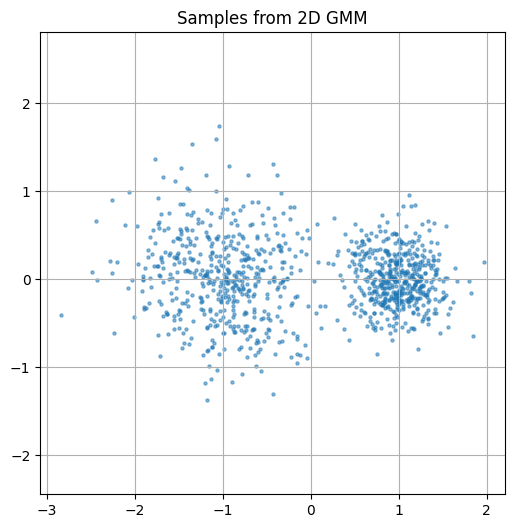

In [12]:
N = 1000

def sample_gmm(N, mu1, mu2, sigma1, sigma2, p):
    choices = torch.bernoulli(torch.full((N,), p)).bool()
    z = torch.randn(N, 2)
    comp1 = z * sigma1 + mu1
    comp2 = z * sigma2 + mu2
    samples = torch.where(choices[:, None], comp1, comp2)
    return samples

mu1 = torch.tensor([1.0, 0.0])
mu2 = torch.tensor([-1.0, 0.0])
sigma1 = 0.3
sigma2 = 0.5
p = 0.5

samples = sample_gmm(N, mu1, mu2, sigma1, sigma2, p)

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.title("Samples from 2D GMM")
plt.axis("equal")
plt.grid(True)
plt.show()

Sample 1000 points using the score model (Langevin Dynamics).

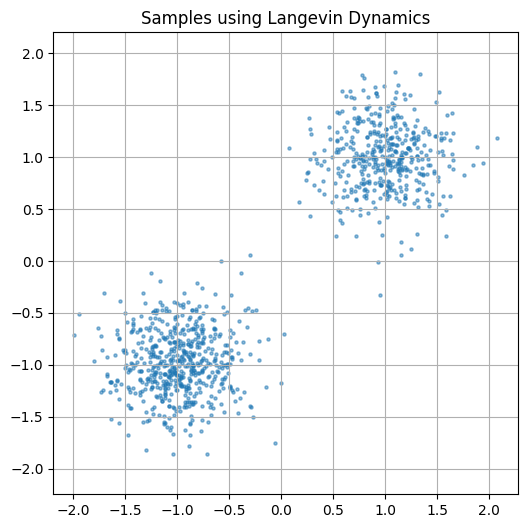

In [13]:
LANGEVIN_STEP_SIZE = 0.01
LANGEVIN_NUM_STEPS = 10000

N = 1000
samples = torch.randn(N, 2)
samples.requires_grad = True

for step in range(LANGEVIN_NUM_STEPS):
    samples = samples.detach().requires_grad_()
    score = gmm_score_model(samples)
    noise = torch.randn_like(samples)
    samples = samples + 0.5 * (LANGEVIN_STEP_SIZE ** 2) * score + LANGEVIN_STEP_SIZE * noise

samples = samples.detach()

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.title("Samples using Langevin Dynamics")
plt.axis("equal")
plt.grid(True)
plt.show()


Sample 1000 points using Annealed Langevin Dynamics and the true score function. Show the sample after applying each noise scale.
Remember that as the noise is smaller, we want to decrease the step size of Langevin Dynamics, so remember to update the step size according to the following formula:

$$\eta_t = \eta_\text{original} \cdot \frac{\sigma_t^2}{\sigma_T^2}$$

Because we are using normal distributions, the noised distributions $p_\sigma$ will just have more variance.

Noise level 1/10, sigma = 2.0000
Noise level 2/10, sigma = 1.1101
Noise level 3/10, sigma = 0.6162
Noise level 4/10, sigma = 0.3420
Noise level 5/10, sigma = 0.1898
Noise level 6/10, sigma = 0.1054
Noise level 7/10, sigma = 0.0585
Noise level 8/10, sigma = 0.0325
Noise level 9/10, sigma = 0.0180
Noise level 10/10, sigma = 0.0100
Final step size: 7.499999696847226e-07
Final noise level: 0.009999999776482582


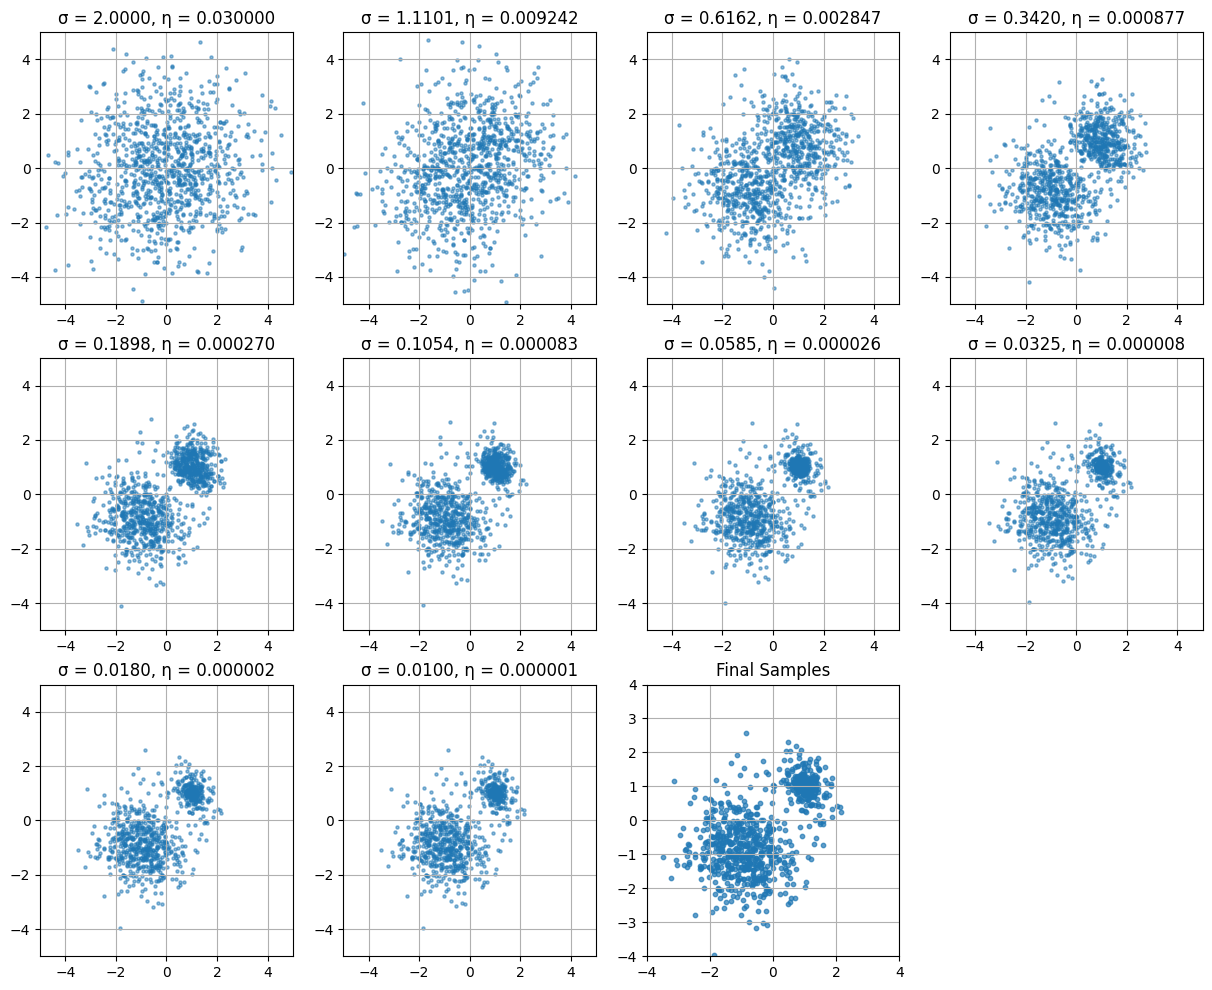

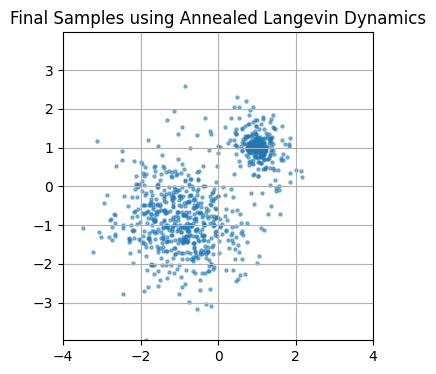

In [14]:
NUM_SAMPLES = 1000
L = 10
EPSILON = 0.03
T = 100
sigma_L = 2.0
sigma_1 = 0.01
sigmas = torch.exp(torch.linspace(np.log(sigma_L), np.log(sigma_1), L))

samples = torch.randn((NUM_SAMPLES, 2))
plt.figure(figsize=(15, 12))
sigma, eta_i = 0, 0
for i, sigma in enumerate(sigmas): # 1 to L
    print(f"Noise level {i+1}/{L}, sigma = {sigma:.4f}")

    eta_i = EPSILON * (sigma ** 2/ sigma_L ** 2)

    for t in range(T):
        samples = samples.detach().requires_grad_()
        score = score_gmm(samples, mu_1, mu_2, torch.sqrt(sigma_1**2 + sigma**2),
                                                    torch.sqrt(sigma_2**2 + sigma**2), p_first)
        samples = samples + (eta_i / 2) * score + torch.sqrt(eta_i) * torch.randn_like(samples)

    plt.subplot(3, 4, i + 1)
    with torch.no_grad():
        plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), s=5, alpha=0.5)
        plt.title(f"σ = {sigma:.4f}, η = {eta_i:.6f}")
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.grid(True)

plt.subplot(3, 4, 11)
with torch.no_grad():
    plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), s=10, alpha=0.7)
    plt.title("Final Samples")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.grid(True)


print("Final step size:", eta_i.item() if isinstance(eta_i, torch.Tensor) else eta_i)
print("Final noise level:", sigma.item() if isinstance(sigma, torch.Tensor) else sigma)

plt.figure(figsize=(4, 4))
with torch.no_grad():
    plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), s=5, alpha=0.5)
    plt.title("Final Samples using Annealed Langevin Dynamics")
    plt.axis("equal")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.grid(True)
plt.show()

## Putting it all together!

In this section you will be using everything you learned to generate images from MNIST, provided to you in your virtual machines (and available in Pytorch). Ideas are based on the paper Generative Modeling by Estimating Gradients of the Data Distribution (2019). You can use the paper's official implementation as a guideline to the solution. It is recommended to go over the first tutorial before solving.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1 - Denoising Score Matching

When the score function cannot be calculated directly (as above), we cannot simply use the MSE between the model output and the true score. Hence, we updated loss function, suiting it to our annealed noise schedule:

$$\ell_\text{denoise}(\theta; \sigma) := \frac{1}{2}\mathbb{E}_{x\sim p_\text{data}} \mathbb{E}_{\tilde{x}\sim q_\sigma(\cdot | x)} \left[ \Vert s_\theta(\tilde{x}, \sigma) - \log q_\sigma(\tilde{x}|x)\Vert^2 \right]$$
$$  L_\text{denoise}(\theta) = \frac{1}{L}\sum_{i=1}^L \lambda(\sigma_i)\ell_\text{denoise}(\theta; \sigma_i) \equiv \mathbb{E}_{i \sim \text{Uni}(1, L)} \left[ \sigma_i^2\ell_\text{denoise}(\theta; \sigma_i) \right] $$

Where the model is denoted as $s_\theta$ and $\sigma_i$ are the noise values.

In [3]:
def denoising_score_loss(model, x, noise_scales):
    """
    model: The score matching model.
    x: The input data [BATCH_SIZE, WIDTH, HEIGHT]
    noise_scales: The noise scales to use for denoising [NUM_NOISE_SCALES] (sigma_1, sigma_2, ..., sigma_L)
    """
    noise_scale_idx = torch.randint(0, len(noise_scales), (x.shape[0],), device=device)  # Random noise scale for each sample in the batch
    sigma = noise_scales[noise_scale_idx].view(-1, 1, 1, 1)  # all entries in an image x should be perturbed by the same noise scale

    ### YOUR CODE HERE ###
    noise = torch.randn_like(x)
    x_tilde = x + sigma * noise  # Perturbed input
    score_pred = model(x_tilde, sigma)  # shape [B, C, H, W]
    target = -noise / (sigma ** 2)  # Target for denoising
    loss = 0.5 * (sigma ** 2) * ((score_pred - target) ** 2)
    loss = loss.view(x.shape[0], -1).sum(dim=1)  # Sum over pixels for each image
    return loss.mean()

### 2 - UNet

A great candidate for a model that receives an image and returns a value that is of the same dimensions as the image is a UNet. Below is a UNet architecture already implemented for you. In this section you don't need to implement / change anything, if you do please specify your changes below.

In [4]:
class CondInstanceNorm(nn.Module):
    def __init__(self, in_channels, n_noise_scale=10, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(n_noise_scale, in_channels))
        self.beta = nn.Parameter(torch.zeros(n_noise_scale, in_channels))
        self.alpha = nn.Parameter(torch.zeros(n_noise_scale, in_channels))
        self.eps = eps

    def forward(self, x, noise_scale_idx):
        bsz = x.shape[0]
        gamma = self.gamma[noise_scale_idx].view(bsz, -1, 1, 1)  # (bsz, in_channels, 1, 1)
        beta = self.beta[noise_scale_idx].view(bsz, -1, 1, 1)
        alpha = self.alpha[noise_scale_idx].view(bsz, -1, 1, 1)


        mu = x.mean(dim=(2, 3), keepdim=True)  # (batch_size, in_channels, 1, 1)
        var = x.var(dim=(2, 3), keepdim=True)  # (batch_size, in_channels, 1, 1)
        sigma = torch.sqrt(var + self.eps)  # (batch_size, in_channels, 1, 1)


        x = (x - mu) / sigma  # (batch_size, in_channels, height, width)
        x = gamma * x + beta  # (batch_size, in_channels, height, width)

        m = mu.mean(dim=1, keepdim=True)  # (batch_size, 1, 1, 1)
        if mu.shape[1] == 1:
            s = torch.ones_like(mu)
        else:
            v = mu.var(dim=1, keepdim=True)  # (batch_size, 1, 1, 1)
            s = torch.sqrt(v + self.eps)  # (batch_size, 1, 1, 1)

        x = x + alpha * (mu - m) / s  # (batch_size, in_channels, height, width)
        return x


class ResidualConvUnit(nn.Module):
    def __init__(self, channels, norm=True, kernel_size=3, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(channels, n_noise_scale) if norm else None
        self.norm2 = CondInstanceNorm(channels, n_noise_scale) if norm else None
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)
        h = self.norm1(x, noise_scale_idx) if self.norm1 is not None else x
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx) if self.norm2 is not None else h
        h = self.act(h)
        h = self.conv2(h)

        return x + h



class StridedConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(in_channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(out_channels, n_noise_scale)
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx)
        h = self.act(h)
        h = self.conv2(h)

        return h


class DilatedConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=2, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=dilation)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(in_channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(out_channels, n_noise_scale)
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx)
        h = self.act(h)
        h = self.conv2(h)

        return h



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_layers=2, downsample='stride', dilation=2, n_noise_scale=10):
        assert downsample in ['stride', 'dilation']
        super().__init__()
        self.downsample = downsample
        self.main = nn.ModuleList([])
        for _ in range(n_layers):
            self.main.append(ResidualConvUnit(in_channels, n_noise_scale=n_noise_scale))

        if downsample == 'stride':
            self.main.append(StridedConvUnit(in_channels, out_channels, n_noise_scale=n_noise_scale))
        elif downsample == 'dilation':
            self.main.append(DilatedConvUnit(in_channels, out_channels, dilation=dilation, n_noise_scale=n_noise_scale))

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        for layer in self.main:
            x = layer(x, noise_scale_idx)

        return x


class AdaptiveConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = ResidualConvUnit(out_channels, n_noise_scale=n_noise_scale)
        self.conv3 = ResidualConvUnit(out_channels, n_noise_scale=n_noise_scale)

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.conv1(x)
        h = self.conv2(h, noise_scale_idx)
        h = self.conv3(h, noise_scale_idx)

        return h


class MultiResolutionFusion(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        self.norm1 = CondInstanceNorm(channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(channels, n_noise_scale)

    def forward(self, x, y=None, noise_scale_idx=0):
        if y is None:
            return x
        else:
            h1 = self.norm1(x, noise_scale_idx)
            h1 = self.conv1(h1)

            h2 = self.norm2(y, noise_scale_idx)
            h2 = self.conv2(h2)

            return h1 + h2


class ResidualPoolingBlock(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.norm1 = CondInstanceNorm(channels, n_noise_scale)
        self.pool1 = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.norm2 = CondInstanceNorm(channels, n_noise_scale)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')

    def forward(self, x, noise_scale_idx):
        h = self.norm1(x, noise_scale_idx)
        h = self.pool1(h)
        h = self.norm2(h, noise_scale_idx)
        h = self.conv1(h)

        return h


class ChainedResidualPool(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.act = nn.ELU()
        self.pool1 = ResidualPoolingBlock(channels, n_noise_scale=n_noise_scale)
        self.pool2 = ResidualPoolingBlock(channels, n_noise_scale=n_noise_scale)


    def forward(self, x, noise_scale_idx):
        x = self.act(x)
        h = self.pool1(x, noise_scale_idx)
        x = x + h
        h = self.pool2(h, noise_scale_idx)
        x = x + h

        return x

class RefineNetBlock(nn.Module):
    def __init__(self, x1_in, x2_in, channels, n_noise_scale=10):
        super().__init__()
        self.adap_x1 = AdaptiveConvBlock(x1_in, channels, n_noise_scale=n_noise_scale)
        self.adap_x2 = AdaptiveConvBlock(x2_in, channels, n_noise_scale=n_noise_scale)

        self.fusion = MultiResolutionFusion(channels, n_noise_scale=n_noise_scale)
        self.pool = ChainedResidualPool(channels, n_noise_scale=n_noise_scale)

        self.out = ResidualConvUnit(channels, n_noise_scale=n_noise_scale)

    def forward(self, x1, x2=None, noise_scale_idx=0):
        h1 = self.adap_x1(x1, noise_scale_idx)
        h2 = self.adap_x2(x2, noise_scale_idx) if x2 is not None else None
        h = self.fusion(h1, h2, noise_scale_idx)
        h = self.pool(h, noise_scale_idx)
        h = self.out(h, noise_scale_idx)

        return h


class RefineNet(nn.Module):
    def __init__(self, in_channels, hidden_channels=(128, 256), n_noise_scale=10):
        super().__init__()
        self.res1 = ResidualBlock(in_channels, hidden_channels[0], n_layers=2, downsample='stride')
        self.res2 = ResidualBlock(hidden_channels[0], hidden_channels[1], n_layers=2, downsample='dilation', dilation=2)
        ### YOU CAN ADD MORE RESIDUAL BLOCKS HERE ###

        self.refine1 = RefineNetBlock(x1_in=hidden_channels[-1], x2_in=hidden_channels[-1], channels=hidden_channels[-1], n_noise_scale=n_noise_scale)
        self.refine2 = RefineNetBlock(x1_in=hidden_channels[-2], x2_in=hidden_channels[-1], channels=hidden_channels[-2], n_noise_scale=n_noise_scale)
        ### EVERY RESIDUAL BLOCK SHOULD BE FOLLOWED BY A REFINE BLOCK ###

        self.up_norm = CondInstanceNorm(hidden_channels[-2], n_noise_scale)
        self.up_conv = nn.ConvTranspose2d(hidden_channels[-2], hidden_channels[-2], kernel_size=3, stride=2, padding=1, output_padding=1)
        self.out = AdaptiveConvBlock(hidden_channels[-2], in_channels, n_noise_scale=n_noise_scale)


    def forward(self, x, noise_scale_idx):
        h1 = self.res1(x, noise_scale_idx)
        h2 = self.res2(h1, noise_scale_idx)

        h = self.refine1(h2, x2=None, noise_scale_idx=noise_scale_idx)  # As we know, U-Nets accept two inputs (previous layer and skip connection)
        h = self.refine2(h1, h, noise_scale_idx)

        h = self.up_norm(h, noise_scale_idx)
        h = self.up_conv(h)
        h = self.out(h, noise_scale_idx)

        return h

def q_sample(x, sigma, noise=None):
    # x: (B, C, H, W)
    # sigma: (B, )
    if noise is None:
        noise = torch.randn_like(x)
    while sigma.dim() < x.dim():
        sigma = sigma.unsqueeze(-1)
    return x + sigma * noise



### 3 - Training

Train a UNet according to the loss implemented above on MNIST. It is recommended to save checkpoints - the model's state dict in case of the machine turning off / crashing (the code should not need to run more than an hour anyways). All hyperparameters have been provided to you and should work in the case everything was implemented correctly. However, you are free to change any values for better performance.

In [5]:
N_EPOCHS = 30
BATCH_SIZE = 64
NOISE_SCALES = torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device)
LR = 1e-3  # Learning rate for the training - not the same as the step size of Langevin Dynamics
NUM_LANGEVIN_STEPS = 100  # Number of steps of Langevin Dynamics for each noise scale.
LANGEVIN_STEP_SIZE = 2e-5  # Base step size in Annealed Langevin Dynamics

In [6]:
# use MNIST as train set
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 17922766.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 443110.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 4047981.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3525916.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RefineNet(in_channels=1, hidden_channels=(128, 256), n_noise_scale=10).to(device)
# model.load_state_dict(torch.load('dsm_model.pth', map_location=device))

L = 10
sigma_levels = NOISE_SCALES.to(device)
sigma_levels_squared = sigma_levels ** 2

optimizer = optim.Adam(model.parameters(), lr=LR)
num_epochs = 60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, _) in tqdm(enumerate(trainloader), total=len(trainloader)):
        x = x.to(device, non_blocking=True)  # Shape: (B, 1, H, W)
        B = x.size(0)

        # Sample noise levels
        noise_idx = torch.randint(0, L, (B,), device=device)
        sigma = sigma_levels[noise_idx].view(B, 1, 1, 1)
        sigma_squared = sigma_levels_squared[noise_idx].view(B, 1, 1, 1)

        # Add Gaussian noise
        epsilon = torch.randn_like(x)
        x_tilde = x + sigma * epsilon

        # Predict score
        score_pred = model(x_tilde, noise_idx)
        target_score = -epsilon / sigma

        # DSM loss: weighted squared error
        sq_error = 0.5 * ((score_pred - target_score) ** 2).view(B, -1).sum(dim=1)
        weighted_loss = (sigma.view(B) ** 2) * sq_error
        loss = weighted_loss.mean()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    torch.save(model.state_dict(), 'dsm_model.pth')
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(trainloader):.4f}")

100%|██████████| 937/937 [04:49<00:00,  3.23it/s]


Epoch [1/60] Loss: 104.6433



100%|██████████| 937/937 [04:39<00:00,  3.35it/s]



Epoch [2/60] Loss: 64.9943


100%|██████████| 937/937 [04:39<00:00,  3.35it/s]



Epoch [3/60] Loss: 45.8747


  7%|▋         | 63/937 [00:18<04:20,  3.36it/s]

### 4 - Sampling

Generate images using Annealed Langevin Dynamics with the model you have trained above. Visualize the process, you can use the function below or any other method. The images do not need to be perfect but it must be clear that they are handwritten digits with a black background. Example imperfect output:

![image.png](attachment:image.png)

Generating images using Annealed Langevin Dynamics...
Visualizing generation process...


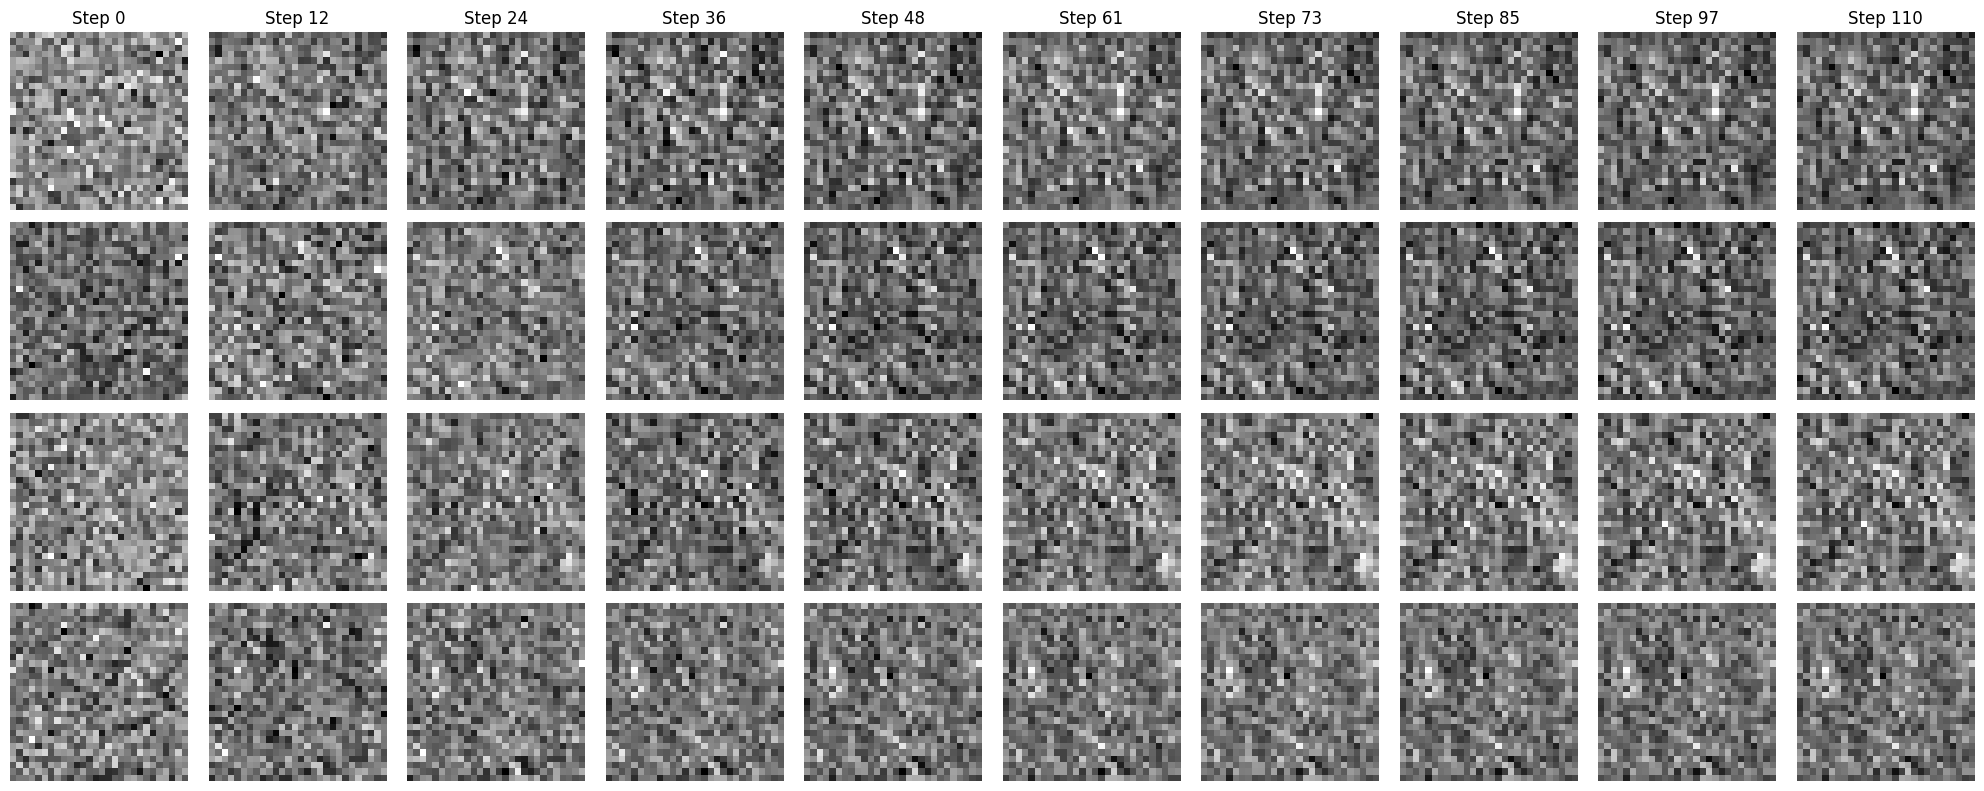

In [ ]:
model = RefineNet(in_channels=1, hidden_channels=(128, 256), n_noise_scale=10).to(device)
model.load_state_dict(torch.load('unet_model.pth', map_location=device))
model.eval()

L = 10
T = 100
img_size = 28
epsilon = 0.00002
sigma_levels = torch.linspace(2.0, 0.01, L)

@torch.no_grad()
def annealed_langevin_dynamics(model, sigmas, n_steps_each=100, step_lr=0.00002, shape=(64, 1, 28, 28), device='cuda'):
    model.eval()
    x = torch.randn(*shape, device=device)
    intermediate_steps = []

    for i in reversed(range(len(sigmas))):
        sigma = sigmas[i]
        sigma_val = sigma.item()
        step_size = step_lr * (sigma_val / sigmas[-1].item()) ** 2
        sigma_idx = torch.full((shape[0],), i, dtype=torch.long, device=device)

        for step in range(n_steps_each):
            x.requires_grad_(True)
            score = model(x, sigma_idx)
            noise = torch.randn_like(x)
            x = x + 0.5 * step_size * score + torch.sqrt(torch.tensor(step_size, device=device)) * noise
            x = x.detach()
            if step % (n_steps_each // 10) == 0 or step == n_steps_each - 1:
                intermediate_steps.append(x.cpu().clone())  # store copy

    return intermediate_steps

print("Generating images using Annealed Langevin Dynamics...")
intermediate_steps = annealed_langevin_dynamics(model, sigmas=NOISE_SCALES.to(device))

def plot_generation_process(steps, n_samples=4):
    n_steps = len(steps)
    fig, axes = plt.subplots(n_samples, min(n_steps, 10), figsize=(20, 2 * n_samples))

    step_indices = np.linspace(0, n_steps - 1, min(n_steps, 10)).astype(int)

    for i in range(n_samples):
        for j, step_idx in enumerate(step_indices):
            img = steps[step_idx][i, 0].numpy()
            ax = axes[i, j] if n_samples > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Step {step_idx}")

    plt.tight_layout()
    plt.savefig('generation_process.png')
    plt.show()

print("Visualizing generation process...")
plot_generation_process(intermediate_steps)
